In [10]:
from utils.CoopEnvalt import CoopEnv
from utils.IACagent import Agent

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [12]:
# Set constant hyperparameters
n = 10
tasks = 5
num_of_sims = 1
step_limit = 500

In [13]:
env = CoopEnv(n=n, tasks=tasks)
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
comm_rec_actions = np.zeros((step_limit+1, env.n))
action_size = env.tasks

In [14]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        agentlist = {i: Agent(action_size) for i in range(env.n)}
        # reset the environment
        observations = env.reset(n=n, tasks=tasks)

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')
            sys_actions = np.zeros((env.n, 2)) # column 0 for move actions and column 1 for comm actions
            # collect move and comm  action for each agent
            sys_actions = np.array([agentlist[i].choose_action(observations[i]) for i in range(env.n)])
            next_observations, rewards, termination, info = env.step(sys_actions) # env.step
            comm_rec_actions[t] = sys_actions[:,1] # output from actor (comm head)

            for C in env.CS: # train each agent

                if len(C)>0:
                    list_of_gradients_actor = []
                    list_of_gradients_critic = []
                    agent_indices = [int(a)-1 for a in list(C)]

                    for i in agent_indices:
                        actor_grad, critic_grad = agentlist[i].train(observations[i], sys_actions[i, :], rewards[i], next_observations[i])
                        list_of_gradients_actor.append(actor_grad)
                        list_of_gradients_critic.append(critic_grad)

                    acc_grad_actor = [tf.zeros_like(t) for t in list_of_gradients_actor[0]]
                    acc_grad_critic = [tf.zeros_like(t) for t in list_of_gradients_critic[0]]

                    for grad in list_of_gradients_actor:
                        acc_grad_actor = [acc_grad_actor[j] + tensor for j, tensor in enumerate(grad)]

                    for grad in list_of_gradients_critic:
                        acc_grad_critic = [acc_grad_critic[j] + tensor for j, tensor in enumerate(grad)]

                    for i in range(env.n):

                        agentlist[i].update(acc_grad_actor, acc_grad_critic)

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = (sum(rewards)/env.n) + steps_to_complete[s, t]

            # increment timestep and loop
            t +=1

    np.save(f'n{n}t{tasks}_newmethod.npy', steps_to_complete)



In [15]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


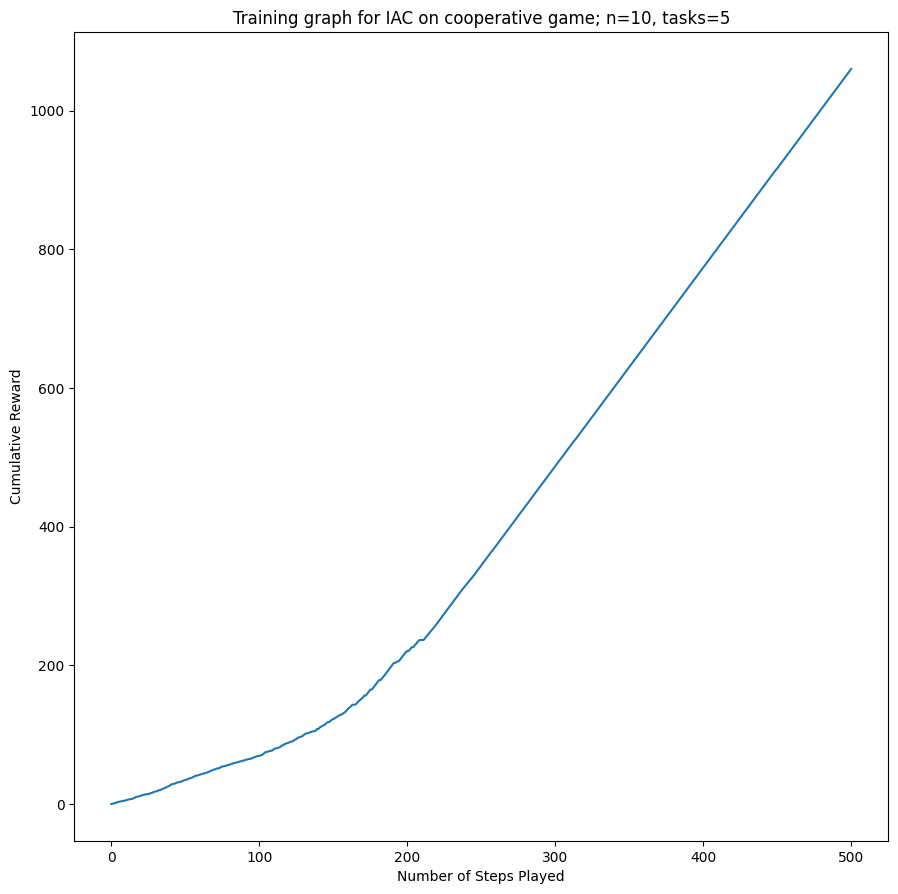

In [16]:
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Reward')
plt.title(f'Training graph for IAC on cooperative game; n={n}, tasks={tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)

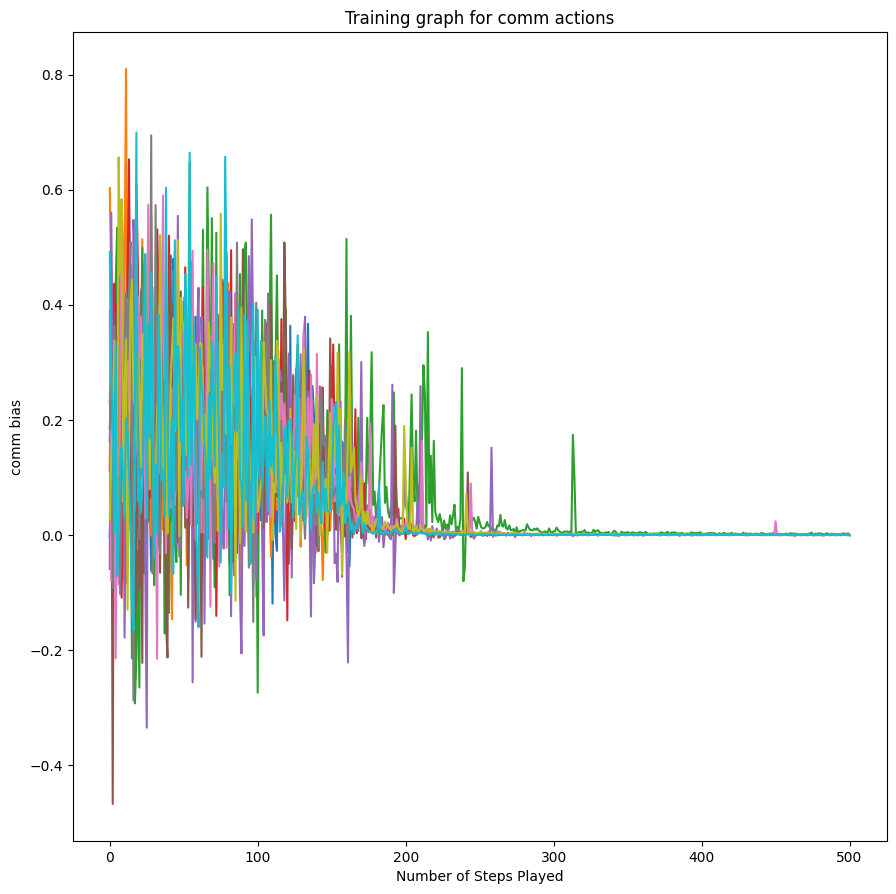

In [17]:
plt.xlabel('Number of Steps Played')
plt.ylabel('comm bias')
plt.title(f'Training graph for comm actions')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(comm_rec_actions)

In [18]:
# Get coalition structure
print(env.CS)


[set(), set(), {'5', '9', '1', '7', '3', '4', '6', '10', '2', '8'}, set(), set()]
